In [1]:
import os
import fnmatch
import fitz #pip install PyMuPDF
import re
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:

#read all PDF files
def find_all_files(path):
    all_files = []

    for root, dirs, files in os.walk(path):
        for file in fnmatch.filter(files,'*.pdf'):
#
            full_path=os.path.abspath(file)
            all_files.append(os.path.join(root, file))
    return all_files

In [53]:
#Specify the path of the folder to look the PDFs of the bills
initial_folder='.'
pdf_files=find_all_files(initial_folder)
# List of every page's text.
# # The index will correspond to the pdf number.
pdf_text = []
for file in pdf_files:
   doc = fitz.open(file)
   text = ""
   for page in doc:
      text+=page.get_text()
   pdf_text.append(text)

In [4]:
#Function to read the amount to pay. It always has the symbol * before the amount (in Euros), e.g., *195,00 
def find_amount(text,amount):
    match=re.search(r'\*\d{1,},\d{1,}',text)
    #add exception when there is a refund and no amount is written
    try:
        #print(match.group(0))
        value=match.group(0)[1:]
        value=value[:-1]
        value=value.replace(',', '.')
        amount.append(float(value))
    except:
        print('Add zero if the bill is negative')
        amount.append(0)
    else:
         pass
    return amount

In [5]:
#Function to read the consumption of kWh 
def find_consumption(text,amount):
    match=re.search(r"\d{1,} kWh|\d.\d{1,} kWh",text)
    #print(match)
    #add exception when there is a refund and no amount is written
    # ATTENTION::: FIX The 
    try:
        #print(match.group(0))
        value=match.group(0).split()
        amount.append(float(value[0]))
    except:
        print('Add zero if there is no consumption')
        amount.append(0)

    return amount

In [63]:
#Function to read the date of consumption 
def find_date(text,begin,end,bill,dts):
    match=re.findall(r"\d{2}/\d{2}/\d{4}",text)
    #print(match)
    #25/06/2022
    #add exception when there is a refund and no amount is written
    # try:
    #     print(match.group(0))
    #     #value=match.group(0).split()
    #     #amount.append(value[0])
    # except:
    #     print('No data for period of consumption available')
    #     amount.append(0)
    #amount.append(match[1:3])
    dts=[]
    for dt in match:
        date_time_obj = datetime.strptime(dt,'%d/%m/%Y')
        #print(date_time_obj)
        dts.append(date_time_obj.date())
        #print(dts)
    #Add date of bill
    #match_bill==re.search(r"Έκδοσης\n\d{2}/\d{2}/\d{4}",text)
    chk=re.match(r"Έκδοσης\n\d{2}/\d{2}/\d{4}",text==True)
    if chk:
        date_time_obj = datetime.strptime(chk,'%d/%m/%Y')
        bill.append(dts[0])
    else:
        bill.append(dts[0])
    #check date because the format of date changes after some bills
    if (dts[1]<dts[2] and dts[2]<dts[3]):
        begin.append(dts[1])
        end.append(dts[2])
    else:
        begin.append(dts[2])
        end.append(dts[3])       
    return begin,end,dts

In [69]:
#re.search(r"Έκδοσης \d{2}/\d{2}/\d{4}",text==True)
re.search(r"Έκδοσης",text==True)

TypeError: expected string or bytes-like object

In [56]:
display(pdf_text[-1])

"  \n  \nΑΔΜΗΕ-ΔΕΔΔΗΕ ....:\n8,12\nΥΚΩ..............:\n1,93\nΕΤΜΕΑΡ...........:\n4,76\nΛΟΙΠΕΣ ΧΡΕΩΣΕΙΣ..:\nΔΙΑΦΟΡΕΣ ΧΡΕΩΣΕΙΣ:\n0,29\nΔΗΜΟΣ............:\n25,88\nΕΡΤ .............:\n2,86\nΚΑΤΑΝΑΛΩΣΗ ......:\n280\n1\nΔΕΗ A.E.\nΧαλκοκονδύλη 30, 104 32 Αθήνα,\nΑ.Φ.Μ. 090000045, Δ.Ο.Υ. ΦΑΕ ΑΘΗΝΩΝ\ndei.gr\nΕΞΥΠΗΡΕΤΗΣΗ ΠΕΛΑΤΩΝ ΔΕΗ\nΕΞΥΠΗΡΕΤΗΣΗ ΔΕΔΔΗΕ\n��������\n000128248097\n�������������������������\n�������������������������\n�������������������������\n�������������������������\nΣκανάρετε\nγια άμεση εξόφληση\n800 900 1000 (ΔΩΡΕΑΝ)\nΚΑΤΑΣΤΗΜΑ ΛΑΡΙΣΑΣ\nΚΑΡΔΙΤΣΑΣ 99 & ΑΜΟΡΓΟΥ 413 35\n800 400 4000 (ΔΩΡΕΑΝ)\nΠληροφορίες | Βλάβες |\nΚαταμέτρηση\n016698\nΤΣΙΜΠΟΥΚΗΣ ΑΘΑΝΑΣΙΟΣΧΡΗΣΤΟΣ\n25ΗΣ ΜΑΡΤΙΟΥ 25\n412 21 ΛΑΡΙΣΑ\n5\nΚωδικός ηλεκτρονικής πληρωμής\nRF53907738000300005250337\n������������������������\n000000089,00  3\nΈναντι\nλογαριασμός\nΤιμολόγιο:\n myHome Open Ν\nΔιεύθυνση ακινήτου:\n25ΗΣ ΜΑΡΤΙΟΥ 25\n412 21 ΛΑΡΙΣΑ\nΕπόμενη καταμέτρηση:\n23/06/2023\nΑριθμός παροχής\n4 40611581-01 1\nΧρεώσεις προμήθ

In [7]:
# # date in yyyy/mm/dd format
# d1 = dt.datetime(2018, 5, 3)
# d2 = dt.datetime(2018, 6, 1)
  
# # Comparing the dates will return
# # either True or False
# print("d1 is greater than d2 : ", d1 > d2)
# print("d1 is less than d2 : ", d1 < d2)
# print("d1 is not equal to d2 : ", d1 != d2)
from datetime import datetime
date_time_obj = datetime.strptime('30/06/2016','%d/%m/%Y')
date_time_obj_2 = datetime.strptime('20/06/2016','%d/%m/%Y')

In [8]:
print(date_time_obj.date()-date_time_obj_2.date())

10 days, 0:00:00


In [64]:
#Extract the info that we want
#Katanalosi, euro and date
monthly_pay=[]
consumption=[]
begin_consumption=[]
end_consumption=[]
date_bill=[]
dates=[]

#Iterate over the extracted PDF text.
for f in pdf_text:
    #First, find what do we pay each month.
    find_amount(f,monthly_pay)
    #Next, find the date of consumption.
    find_date(f,begin_consumption,end_consumption,date_bill,dates)
    #Finally, find the consumption of kWh.
    find_consumption(f,consumption)


TypeError: expected string or bytes-like object

In [10]:
#fix delimiter in new bills

number = consumption[-1]  # Float value with a point as a thousand separator
tst=str(number).split(".")
print(tst[1]>tst[0])
number = str(number).replace(".", "")  # Remove the point
number = float(number)  # Convert the result back to float
print(number)

False
2800.0


In [11]:
#fix point delimiter considered as thousand in new bills
for month in consumption:
    try:
        #Check if consumption has a point delimiter that denotes thousand instead of decimal
        check=str(month).split(".")
        if check[1]>check[0]: #It is going to have at least 3 values after the point that denotes thousands
            number = str(month).replace(".", "")  # Remove the point
            consumption[consumption.index(month)] = float(number)  # Convert the result back to float
    except:
        pass

In [46]:
# Calling DataFrame constructor after zipping
# both lists, with columns specified
df = pd.DataFrame(list(zip(begin_consumption, end_consumption,consumption,monthly_pay)),
               columns =['Start', 'End','Consumption','Bill'])
# forming dataframe
data = pd.DataFrame(df) 

#
# storing into the excel file
#data.to_excel("output.xlsx")

In [37]:
#df.groupby(pd.to_datetime(df['Start of consumption']).dt.year).sum()

df['quarter'] = pd.to_datetime(df['End']).dt.quarter
df['year'] = pd.to_datetime(df['End']).dt.year
#df.quarter=df.quarter.astype(str)
#df.groupby(df['quarter']).sum()
#type(df['quarter'])

In [35]:
#test=df.groupby(df['quarter']).sum()
#test.dtypes

/tmp/ipykernel_247/1778079388.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test=df.groupby(df['quarter']).sum()


Consumption    float64
Bill           float64
year             int64
dtype: object

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# group data by year and quarter
grouped = df.groupby(['year','quarter']).sum()

# reshape data into a pivot table
pivot = grouped.pivot_table(index='quarter', columns='year', values='Bill', aggfunc=np.sum)

# create the bar chart
ax = pivot.plot(kind='bar', figsize=(10,6))

# set the x-axis label and tick labels
ax.set_xlabel('Quarter')
ax.set_xticklabels(pivot.index, rotation=0)

# set the y-axis label
ax.set_ylabel('Bill [Euro]')

# set the legend
ax.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

AttributeError: 'DataFrameGroupBy' object has no attribute 'isnull'

TypeError: the dtypes of parameters x (object) and width (float64) are incompatible

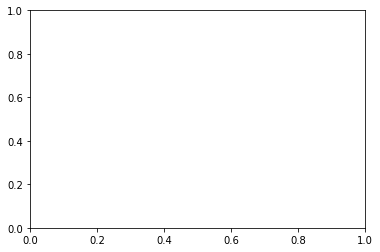

In [ ]:
# # Bar chart 
fig, ax = plt.subplots()
ax.bar(test.index, test['Bill [EURO]'])


#plt.bar(,)
 
plt.title("Bar Chart")
 
# Setting the X and Y labels
plt.xlabel('Date')
plt.ylabel('Bill [EURO]')
 
# Adding the legends
plt.show()


# Scatter plot with day against tip
# plt.plot(df['Bill [EURO]'])
 
# # Adding Title to the Plot
# plt.title("Scatter Plot")
 
# # Setting the X and Y labels
# plt.xlabel('Day')
# plt.ylabel('Bill [EURO]')
 
# plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt



# group data by year and quarter
grouped = df.groupby(['Year', 'Quarter']).sum()

# reshape data into a pivot table
pivot = grouped.pivot_table(index='Quarter', columns='Year', values='Value')

# create the bar chart
ax = pivot.plot(kind='bar', figsize=(10,6))

# set the x-axis label and tick labels
ax.set_xlabel('Quarter')
ax.set_xticklabels(pivot.index, rotation=0)

# set the y-axis label
ax.set_ylabel('Value')

# set the legend
ax.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

# set height of bar
Q1 = [12, 30, 1, 8, 22]
Q2 = [28, 6, 16, 5, 10]
Q3 = [29, 3, 24, 25, 17]
Q4 = [29, 3, 24, 25, 17]

# Set position of bar on X axis
br1 = np.arange(len(Q1))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

# Make the plot
plt.bar(br1, Q1, color ='r', width = barWidth,
		edgecolor ='grey', label ='Q1')
plt.bar(br2, Q2, color ='g', width = barWidth,
		edgecolor ='grey', label ='Q2')
plt.bar(br3, Q3, color ='b', width = barWidth,
		edgecolor ='grey', label ='Q3')
plt.bar(br4, Q4, color ='b', width = barWidth,
		edgecolor ='grey', label ='Q4')

# Adding Xticks
plt.xlabel('Branch', fontweight ='bold', fontsize = 15)
plt.ylabel('Students passed', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(Q1))],
		['2015', '2016', '2017', '2018', '2019'])

plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

quarters = ['Q1', 'Q2', 'Q3', 'Q4']
year1 = [100, 150, 200, 250]
year2 = [125, 175, 225, 275]
year3 = [110, 170, 210, 280]

x = np.arange(len(quarters))  # the x locations for the quarters
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, year1, width, label='Year 1')
rects2 = ax.bar(x, year2, width, label='Year 2')
rects3 = ax.bar(x + width, year3, width, label='Year 3')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Energy Bill')
ax.set_title('Energy Bills by Quarter and Year')
ax.set_xticks(x)
ax.set_xticklabels(quarters)
ax.legend()

fig.tight_layout()

plt.show()


/tmp/ipykernel_247/241010218.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_year=df.groupby(pd.to_datetime(df['Start']).dt.year).sum()


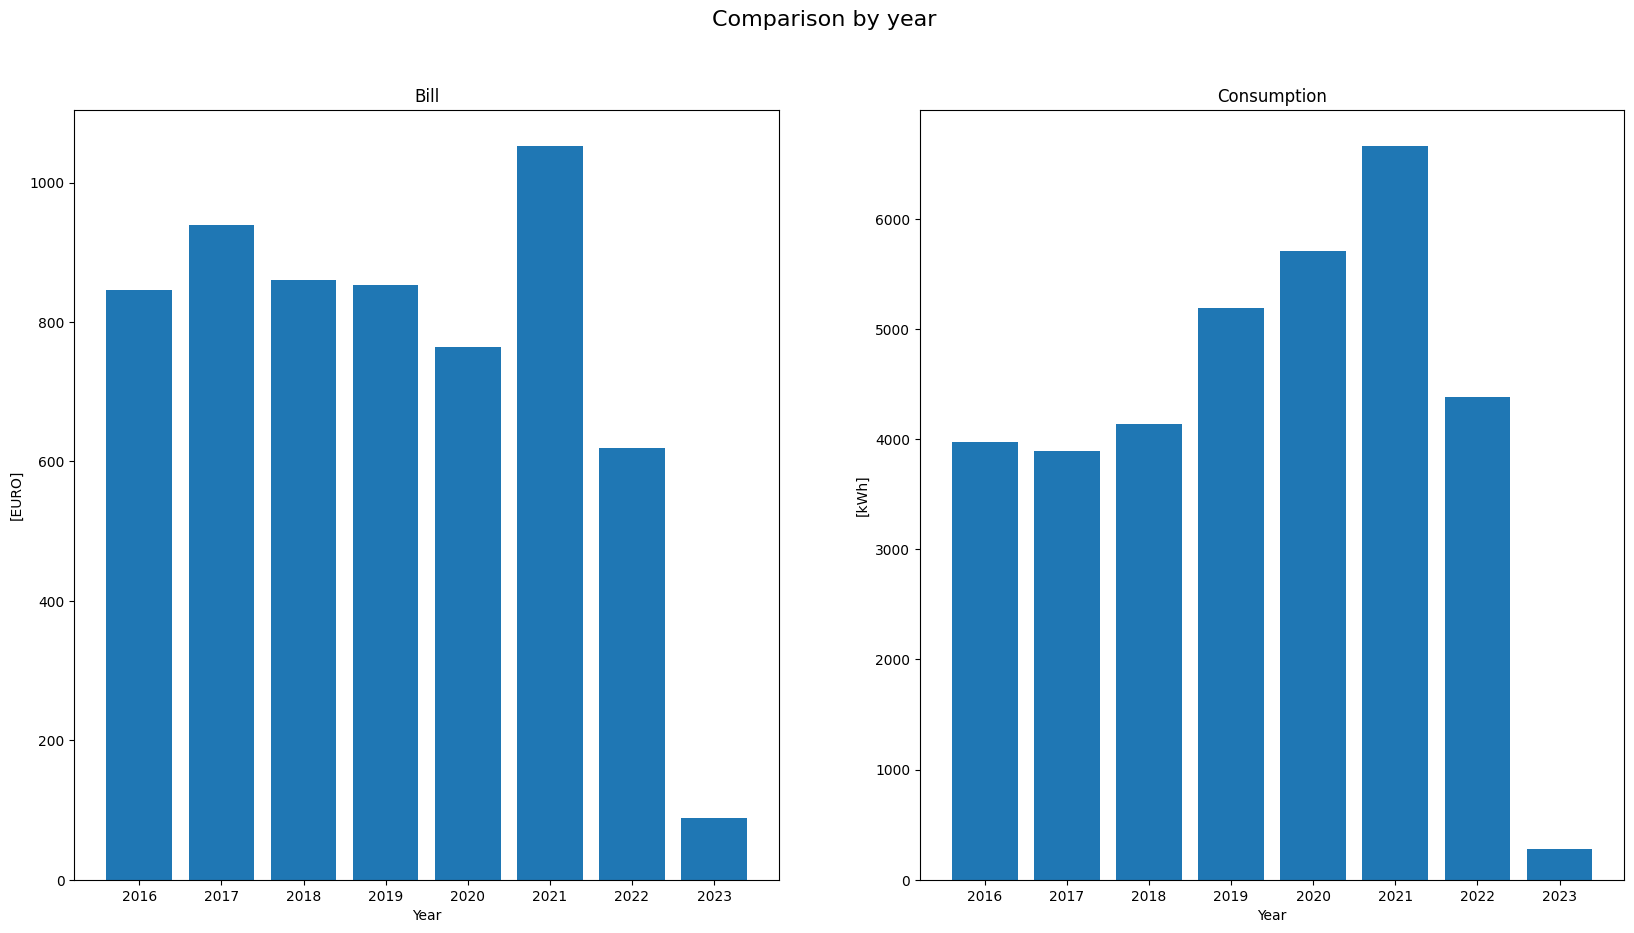

In [43]:
#Results for each a year
df_year=df.groupby(pd.to_datetime(df['Start']).dt.year).sum()

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Plot the first bar figure in the left subplot
axs[0].bar(df_year.index, df_year['Bill'])
axs[0].set_title('Bill')
axs[0].set_ylabel('[EURO]')
axs[0].set_xlabel('Year')
# Plot the second bar figure in the right subplot
axs[1].bar(df_year.index, df_year['Consumption'])
axs[1].set_title('Consumption')
axs[1].set_ylabel('[kWh]')
axs[1].set_xlabel('Year')
# Add a title to the overall figure
fig.suptitle('Comparison by year', fontsize=16)
# Display the plot
plt.show()


In [ ]:
#pdf_files
#pdf_text[-1]

#PyPDF2 doenst work!
# for file in pdf_files[0:1]:
#     f = open(file,'rb')

#     # List of every page's text.
#     # The index will correspond to the page number.
#     pdf_text = []

#     pdf_reader = PyPDF2.PdfReader(f)

#     for p in range(len(pdf_reader.pages)):
        
#         single_page = pdf_reader.pages[p]

#         pdf_text.append(single_page.extract_text())